In [1]:
import pandas as pd

from clv_predictor.clv_predictor import CLVPredictor
from clv_predictor.data_preparer import DataPreparer
from matplotlib import pyplot as plt

In [2]:
base_path = "data/case_study_base_anon.csv"
xs_path = "data/case_study_xs_anon.csv"

## 0. General problem definition

We will tackle the problem as 2 separate parts:
1. Predict 12-month CLV based on the customer base data
2. Predict total cross-sell CLV based on the cross sell data joined with customer base features and added negative samples

For a given new customer, we can then predict the total CLV by adding up the predictions of both models

## 1. Predict 12-month CLV based on customer base data

### 1.1 Problem overview and data preparation

We'll estimate the 12-month CLV for a given customer, based on the features listed below. 

Note that we are not using any duration related features, as we assume that, as we want to estimate CLV for new customers, we won't yet know how long they are subscribed to a product with Getsafe and thus shouldn't use this information as a feature. In the future, a model that takes into account duration could be explored, predictions with it could be produced on a rolling basis for active customers as their duration information is updated

For the current solution however, the specifications are as follows:

Dependent variable: user-level 12-month CLV

Features: product, commission, channel, age_bucket, operating_system, month_start, day_start


In order to make our data ready for a machine learning (ML) model, the data_preparer module was created. This module contains the DataPreparer class which performs the necessary data preparation steps identified during the EDA for both the base and cross sale data. The specific data preparation steps for this dataset are explained below

Data preparation steps:
- Read customer base data from csv
- Fill operating_system NaNs with 'undefined': we decided to keep the 'undefined' category as we observed customer behavior associated to low 12 month CLV for it, so without additional knowledge of the data and problem it was prefer to keep it vs fill the values with something that could alter the relationships within the data
- Compute 12-month CLV for observations with full information: observations without crystalized historical 12-month CLV are dropped
- Discard observations with negative historical 12-month CLV
- Split dataframe into features X=["product", "commission", "channel", "age_bucket", "operating_system", "month_start", "day_start"], and dependent variable y="clv_12"
- Separate data into train (80%) and test (20%) sets
- Handle 12-month CLV and commission outliers for train set: the DataPreparer class takes a 'handle_outliers_base' flag to indicate whether we want to substitute outliers' values for the base dataset. The substitution method consists of replacing the outlier values with the upper and lower bound identified through the interquartile range method

Let's initialize our data_preparer to get the data for the customer base model ready

In [3]:
data_preparer = DataPreparer(base_path, xs_path, handle_outliers_flag=True)

We now run the prepare_base_data_for_ml_model method, which will prepare the customer base data by following the data preparation steps mentioned above

In [4]:
data_preparer.prepare_base_data_for_ml_model()

Handle outliers


X_base_train, X_base_test, y_base_train and y_base_test are now stored as attributes of the data_preparer object:

In [5]:
data_preparer.X_base_train.head()

,product,commission,channel,age_bucket,operating_system,month_start,day_start
52991,product_c,15.79125,channel_a,30-34,Android,12,4
11280,product_a,14.47250,channel_a,40-44,Android,8,4
61074,product_a,12.17750,channel_a,55+,Android,1,5
13940,product_a,14.90500,channel_b,18-24,iOS,2,2
64299,product_b,12.24250,channel_b,50-54,iOS,9,4


In [6]:
data_preparer.X_base_test.head()

,product,commission,channel,age_bucket,operating_system,month_start,day_start
71230,product_a,10.0000,channel_a,25-29,Android,7,3
72041,product_a,12.5575,channel_a,30-34,Android,5,3
90635,product_a,12.0475,channel_b,25-29,iOS,7,2
37539,product_a,10.0000,channel_b,18-24,Android,12,3
49487,product_a,12.5050,channel_a,25-29,iOS,7,6


In [7]:
data_preparer.y_base_train.head()

52991    189.605260
11280    173.670000
61074    146.130000
13940    119.566685
64299    146.910000
Name: clv_12, dtype: float64

In [8]:
data_preparer.y_base_test.head()

71230     82.849315
72041     42.523479
90635    144.570000
37539    120.000000
49487    150.060000
Name: clv_12, dtype: float64

### 1.2 Modelling

We tried out 2 models for the problem of predicting the user-level 12-month CLV:

1. Linear regression: chosen due to simplicity, although from EDA some of the linear regression assumptions may not be covered in our data
3. Catboost: chosen due to state of the art status and efficient handling of categorical variables 

We compare the performance of the 2 of them based on the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) metrics, as usual for regression problems

We will compare these 2 models against each other and vs 2 naive baselines:
- Mean of historical CLV-12 of training set as prediction for all users
- Median of historical CLV-12 of training set as prediction for all users

We created clv_predictor module, which contains the CLVPredictor class that fits and trains all of the above models on a given train set, and evaluated them on a given test set, providing a comparison of their performance

Let's initialize it below to predict for our customer base data

In [9]:
clv12_predictor = CLVPredictor(X_train=data_preparer.X_base_train, y_train=data_preparer.y_base_train, \
                               X_test=data_preparer.X_base_test, y_test=data_preparer.y_base_test, \
                               cat_features=["product", "channel", "age_bucket", "operating_system", "month_start", "day_start"], \
                               models=["linear_regression", "catboost", "baseline_median", "baseline_mean"]) 

To fit and compare the performance of the different models for the customer base data, we simply run:

In [10]:
clv12_predictor.compare_regression_performance_all()

Fit all models
Predicts for train and test set with all models
The metrics of the different models on the train dataset are as follows
      linear_regression   catboost  baseline_median  baseline_mean
RMSE          36.451526  34.908477        41.298870      39.682416
MAE           27.805206  25.985167        29.182792      31.379990
The metrics of the different models on the test dataset are as follows
      linear_regression   catboost  baseline_median  baseline_mean
RMSE          56.007696  54.779731        61.878316      60.419559
MAE           36.106641  35.598294        38.571720      40.752903


We already got a summary of the performance of each model above, however, let's look at the metrics for the test set of the base data in a nicer format:

In [11]:
df_base_test_performance = pd.DataFrame(clv12_predictor.eval_dict["test"])

In [12]:
df_base_test_performance

,linear_regression,catboost,baseline_median,baseline_mean
RMSE,56.007696,54.779731,61.878316,60.419559
MAE,36.106641,35.598294,38.571720,40.752903


Under both metrics, catboost is the best performing model although it doesn't seem to be much ahead vs the linear regression model. To further understand the performance of all models, let's have a look at the standard deviation of the test 12-month CLV

In [13]:
clv12_predictor.y_test.describe()

count    18337.000000
mean       132.522900
std         60.385535
min          0.000000
25%        120.000000
50%        146.040000
75%        155.970000
max        712.140000
Name: clv_12, dtype: float64

Comparing the RMSE metric for catboost and linear regression, the value of this metric is lower than the variance of the dependent variable in the test set, however, it's very close in magnitude which is a sign of not a great performance. 

Let's now plot the predictions for y_test vs the real values to understand how they correlate for each model. 

We can see a lot of noise especially when predicting for customers with lower values of y_test. Both catboost and linear regression have a high degree of overestimation in this case. For customers with higher values of y_test, the performance seems to be directionally better for both models, although catboost tends to underestimate in this case

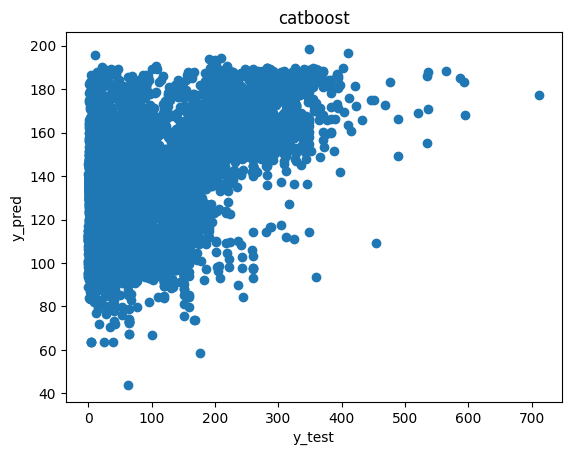

In [14]:
plt.scatter(clv12_predictor.y_test, clv12_predictor.predictions["catboost"]["test"])
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("catboost")
plt.show()
plt.show()

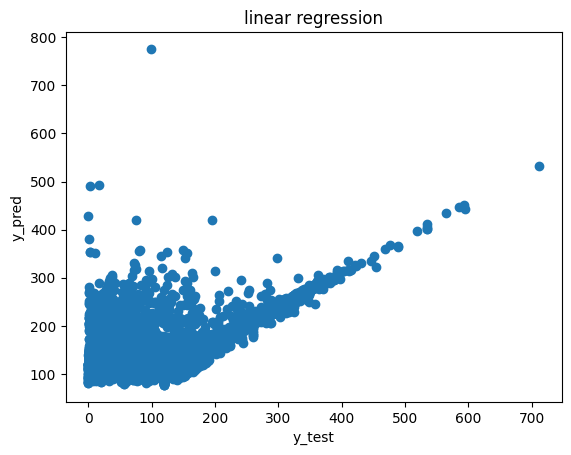

In [16]:
plt.scatter(clv12_predictor.y_test, clv12_predictor.predictions["linear_regression"]["test"])
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("linear regression")
plt.show()
plt.show()

As the goal of the exercise is not to provide an optimal performing model, we will move on to the cross sell data problem and in the last section we will propose some next steps to further assess and improve the performance of all models

## 2. Cross Sell Data

### 2.1 Data preparation

Based on the EDA, we noticed that the cross sell CLV is associated to be higher when customers convert to product_x, however the biggest part of the problem to predict cross sell CLV for a new customer is estimating whether they will convert to cross sell at all. Hence, to simplify the problem, we decided to directly estimate the total cross sell CLV for a given customer, regardless of the cross sell product they converted to, while adding negative samples of historical that did not convert to cross sell so the model can learn the difference between conversion and non-conversion events

In the future, we could create a more nuanced model to predict the cross sell product a customer is likely to convert to (if any) which would potentially help to improve the cross sell CLV estimation. However, as a first experiment we tackle the simpler version of the problem

For the current solution however, the specifications are as below:

Dependent variable: user-level aggregate cross sell CLV

Features: product, commission, channel, age_bucket, operating_system, month_start, day_start, clv_12

Note that we will be using the 12-month CLV as a feature, so to generate the cross sell CLV prediction for a new customer we would need to generate their 12-month CLV prediction and use it as input for the cross sell CLV predictor

Data preparation steps:
- Fill cross sell commission NaNs with median values for each product
- Group cross sell data by user_id to calculate aggregate user-level cross sell CLV 
- Join grouped cross sell data with customer base features
- Extract additional negative samples from customer base dataset
- Split dataframe into features X=["product", "commission", "channel", "age_bucket", "operating_system", "month_start", "day_start", "clv_12"], and dependent variable y="clv_xs"
- Separate data into train (80%) and test (20%) sets

Let's now run the prepare_xs_data_for_ml_model method, which will prepare the cross sell data by following the steps

In [17]:
data_preparer.prepare_xs_data_for_ml_model()

In [18]:
data_preparer.X_xs_train.head()

,product,commission,channel,age_bucket,operating_system,month_start,day_start,clv_12
223,product_a,12.4575,channel_b,30-34,Android,11,1,149.490000
45185,product_a,14.4650,channel_b,18-24,iOS,10,2,173.580000
88818,product_a,12.1775,channel_a,45-49,iOS,12,3,120.106849
229,product_c,25.7100,channel_b,30-34,iOS,10,6,308.520000
396,product_c,15.8100,channel_b,25-29,Android,7,4,189.720000


In [19]:
data_preparer.X_xs_test.head()

,product,commission,channel,age_bucket,operating_system,month_start,day_start,clv_12
42382,product_a,11.5750,channel_a,25-29,Android,1,4,138.90
1065,product_a,12.6275,channel_a,30-34,Android,9,0,151.53
962,product_a,12.1775,channel_a,55+,iOS,11,0,146.13
733,product_a,13.1950,channel_b,25-29,Android,10,0,158.34
726,product_c,21.6600,channel_b,40-44,iOS,4,2,259.92


In [20]:
data_preparer.y_xs_train.head()

223      526.85
45185      0.00
88818      0.00
229      136.00
396      294.13
Name: clv_xs, dtype: float64

In [21]:
data_preparer.y_xs_test.head()

42382       0.0000
1065     1157.0250
962         0.0000
733       661.9025
726       526.8500
Name: clv_xs, dtype: float64

### 2.2 Modelling 

We tried out the same 2 models as we did for the problem of predicting the user-level 12-month CLV:

1. Linear regression
3. Catboost 

We again, compare the performance of the 2 of them based on RMSE and MAE

We will also compare these 2 models against each other and vs the same naive baselines we used before:
- Mean of historical cross sell CLV of training set as prediction for all users
- Median of historical cross sell CLV of training set as prediction for all users

We again use the clv_predictor module to fit and train all of the above models on the given train set, and evaluate them on the test set, providing a comparison of their performance

Let's initialize it below to predict for our cross sell data

In [22]:
clvxs_predictor = CLVPredictor(X_train=data_preparer.X_xs_train, y_train=data_preparer.y_xs_train, \
                               X_test=data_preparer.X_xs_test, y_test=data_preparer.y_xs_test, \
                               cat_features=["product", "channel", "age_bucket", "operating_system", "month_start", "day_start"], \
                               models=["linear_regression", "catboost", "baseline_median", "baseline_mean"])

In [23]:
clvxs_predictor.compare_regression_performance_all()

Fit all models
Predicts for train and test set with all models
The metrics of the different models on the train dataset are as follows
      linear_regression    catboost  baseline_median  baseline_mean
RMSE         547.459827  519.848463       701.498196     584.471300
MAE          359.228914  343.290591       387.934296     411.629421
The metrics of the different models on the test dataset are as follows
      linear_regression    catboost  baseline_median  baseline_mean
RMSE         516.147617  524.205149       657.824277     541.498607
MAE          364.964359  368.666961       373.781152     394.801478


In [24]:
df_xs_test_performance = pd.DataFrame(clvxs_predictor.eval_dict["test"])

In [25]:
df_xs_test_performance

,linear_regression,catboost,baseline_median,baseline_mean
RMSE,516.147617,524.205149,657.824277,541.498607
MAE,364.964359,368.666961,373.781152,394.801478


Under both metrics, linear regression is the best performing model. To further understand the performance of all models, let's have a look at the standard deviation of the test 12-month CLV

In [26]:
clvxs_predictor.y_test.describe()

count     458.000000
mean      373.781152
std       541.905539
min         0.000000
25%         0.000000
50%       121.723750
75%       526.850000
max      3226.800000
Name: clv_xs, dtype: float64

As for the base data, RMSE of the linear regression and catboost models is lower than the standard deviation of y_test, however their magnitud is close which indicates room for improvement in regard to performance

Through the plots below we can further assess the performance for both models. We can see in both cases predictions are very noisy for customers that do not convert to cross sell (y_test=0), as well as for low values of y_test.

Both models have negative predictions. In the case of linear regression, we would need to investigate the regression coefficients to understand what is causing this. In the case of catboost, we would have to investigate overfitting, feature interactions and hyperparameter effect of e.g. learning rate and number of trees to further understand the cause of the problem.

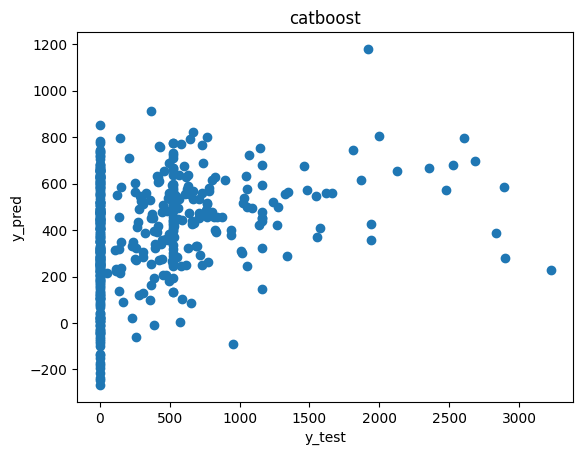

In [27]:
plt.scatter(clvxs_predictor.y_test, clvxs_predictor.predictions["catboost"]["test"])
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("catboost")
plt.show()

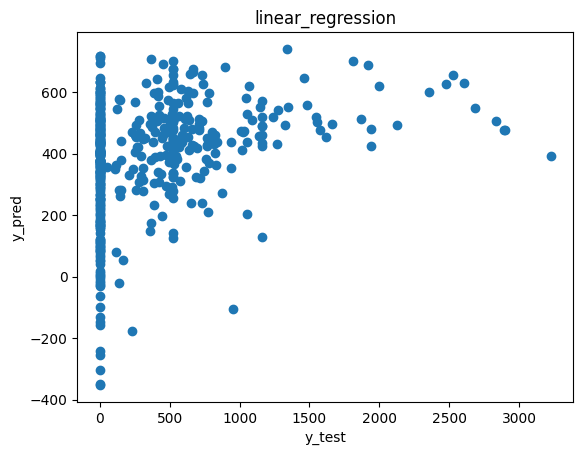

In [28]:
plt.scatter(clvxs_predictor.y_test, clvxs_predictor.predictions["linear_regression"]["test"])
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("linear_regression")
plt.show()

## 3. Further model evaluation and improvement ideas

Due to lack of time we could not further experiment with these ideas to continue the evaluation and improvement of the models:
- To further understand and improve performance of the linear regression models for both cases, we would need to analyze the estimated linear regression coefficients, improve feature selection based on these insights and determine whether regularization would be beneficial. We should also check if in general the assumptions of linear regression remain true through an analysis of residuals. We should additionally define a validation set or perform cross validation based on which we would do hyperparameter tuning e.g. to determine optimal regularization
- In the case of the catboost models, we should further investigate the feature importance scores, improve feature selection based on these, perform hyperparameter tuning based on a validation set or cross validation and plot the learning curves of the training and validation error to understand whether the model is overfitting, underfitting as well as if it requires more data or regularization
- We additionally should assess prediction samples, i.e. identify cases for which the models are performing really good and bad to gain further insights on what needs improving through this analysis
- The problem definition of the cross sell CLV prediction should potentially be adjusted, as we observed a lot of noise for predictions of the non-converted customers. We could potentially do a classification model that would predict the probability of cross sell conversion to either product_x, product_y or both for a new customer and then have another model that estimated cross sell CLV for converted customers
- We could explore doing additional CLV prediction models that take in duration as a feature (e.g. stop assuming we only care about cold start problem for new customers), and update CLV predictions as the customer lifetime as a Getsafe user increases

## 4. What additional data points would you want to consider to improve the prediction and why?

For the 12-month CLV prediction:
- More demographic data about users, e.g. gender, location, income level, occupation, as these could provide insights into subscription patterns
- Churn reason, if there is any data recorded around this, as this could help us to determine patterns leading to different reasons
- Customer service interactions and customer satisfaction data and feedback from user surveys, as these could help us to predict early churn or a lasting customer relationship
- More information regarding commission and how they are determined for a given user, as this variable presents relevant variation for all products and could be useful to have a deeper knowledge of it to determine how it correlated to early churn

For the cross sell CLV prediction (in addition to most of the above):
- Product views, clicks, time spent on product pages, add-to-cart actions, as these could help us to indicate interest of a customer buying a cross sell product
- Search history on app or website, as this could also help to signal interest in a cross sell product
- Promotional offers data, as this could help us to understand further reasons for cross selling
- More datapoints, as the cross sell dataset is quite small

## 5. Further steps to productionize the model

Once we develop a model that performs well and are ready to productionize it, we would proceed to design a python package with modules for at least:
- data preparation
- model train and predict
- model evaluation

We would include unit tests and a continuous integration pipeline that would help us to assess the functionality and performance of the code components. The code would be linted, well commented, with docstrings and type hinting

We would need to determine whether productionizing through a model service or batch prediction. This would depende on the model use case and we would need to further understand this to provide a recommendation

PS: the modules used for data preparation, train and predict in this notebook were designed only for the purposes of this exercise and are not a proposal for how the code should be productionized, e.g. I didn't follow my advice fully re: linting, docstrings and type hinting but would do so if I had had more time :) 